# Objective

Create a model to predict the possibility of a serious accident in the city of Medellin. The model must consider special holiday dates.

# Datasets

The datasets will be obtained from the Medellin's open data portal: https://geomedellin-m-medellin.opendata.arcgis.com/search?tags=movilidad

# Previous Analysis

Let's review the actual data


In [1]:
import pandas as pd

df = pd.read_csv('datasets/2014.csv', dtype='unicode')
df.head()

,OBJECTID,X,Y,RADICADO,HORA,DIA_NOMBRE,PERIODO,CLASE,DIRECCION,DIRECCION_ENC,CBML,TIPO_GEOCOD,GRAVEDAD,BARRIO,COMUNA,DISENO,MES,DIA,FECHA,MES_NOMBRE
0,212279,833182.61,1186704.17,01521,05:35 PM,SÁBADO,2014,Otro,CR 80 CL 79 B - 04,CR 080 079 B 004 00000,07080020017,Nomenclatura con Interior,MUERTO,Altamira,Robledo,NaN,01,11,2014-01-11T00:00:00.000Z,NaN
1,212281,833519.42,1189381.53,1424810,01:00 AM,DOMINGO,2014,Choque,CL 104 DA CR 83,CL 104 DA 083 000 00000,0602,Malla vial,HERIDO,Doce de Octubre No.1,Doce de Octubre,Tramo de via,01,12,2014-01-12T00:00:00.000Z,NaN
2,212282,830522.38,1181389,1424815,12:30 AM,DOMINGO,2014,Volcamiento,CL 32 CR 86,CL 032 086 000 00000,1617,Malla vial,HERIDO,Las Mercedes,Belén,Tramo de via,01,12,2014-01-12T00:00:00.000Z,NaN
3,212283,837395.44,1173135.08,1424820,12:15 AM,DOMINGO,2014,Caída de Ocupante,Tramo 8 Kilometro 7,000,NaN,ZONA RURAL,HERIDO,NaN,NaN,Tramo de via,01,12,2014-01-12T00:00:00.000Z,NaN
4,212284,830992.49,1183205.42,1424830,02:00 AM,DOMINGO,2014,Choque,CL 44 CR 84,CL 044 084 000 00000,1204,Malla vial,HERIDO,La América,La América,Tramo de via,01,12,2014-01-12T00:00:00.000Z,NaN


## Data cleaning

### Values of Interest

As we do not wish to split accidentality by neighborhood, hour of the day or via geological status but with holiday days, our columns of interest will be: _Periodo_ , _Clase_ , _Gravedad_ , _Mes_ , _Dia_ and _Fecha_.

Let's proceed to extract only the variables of interest.

In [2]:
df = df[['PERIODO', 'CLASE', 'GRAVEDAD', 'MES', 'DIA', 'FECHA']]
df.head()

,PERIODO,CLASE,GRAVEDAD,MES,DIA,FECHA
0,2014,Otro,MUERTO,01,11,2014-01-11T00:00:00.000Z
1,2014,Choque,HERIDO,01,12,2014-01-12T00:00:00.000Z
2,2014,Volcamiento,HERIDO,01,12,2014-01-12T00:00:00.000Z
3,2014,Caída de Ocupante,HERIDO,01,12,2014-01-12T00:00:00.000Z
4,2014,Choque,HERIDO,01,12,2014-01-12T00:00:00.000Z


In [3]:
# Extracting the desired data from all the datasets

df_2014 = pd.read_csv('datasets/2014.csv', dtype='unicode')[['PERIODO', 'CLASE', 'GRAVEDAD', 'MES', 'DIA', 'FECHA']]
df_2015 = pd.read_csv('datasets/2015.csv', dtype='unicode')[['PERIODO', 'CLASE', 'GRAVEDAD', 'MES', 'DIA', 'FECHA']]
df_2016 = pd.read_csv('datasets/2016.csv', dtype='unicode')[['PERIODO', 'CLASE', 'GRAVEDAD', 'MES', 'DIA', 'FECHA']]
df_2017 = pd.read_csv('datasets/2017.csv', dtype='unicode')[['PERIODO', 'CLASE', 'GRAVEDAD', 'MES', 'DIA', 'FECHA']]
df_2018 = pd.read_csv('datasets/2018.csv', dtype='unicode')[['PERIODO', 'CLASE', 'GRAVEDAD', 'MES', 'DIA', 'FECHA']]

df_2018.head()

,PERIODO,CLASE,GRAVEDAD,MES,DIA,FECHA
0,2018,Choque,HERIDO,01,14,2018-01-14T00:00:00.000Z
1,2018,Choque,SOLO DAÑOS,01,14,2018-01-14T00:00:00.000Z
2,2018,Caida Ocupante,HERIDO,01,14,2018-01-14T00:00:00.000Z
3,2018,Otro,HERIDO,01,14,2018-01-14T00:00:00.000Z
4,2018,Choque,SOLO DAÑOS,01,14,2018-01-14T00:00:00.000Z


### Values normalization

Some columns values includes accents, we should normalize them

In [4]:
df_2014['CLASE'].unique()

array(['Otro', 'Choque', 'Volcamiento', 'Caída de Ocupante', 'Atropello',
       'Incendio'], dtype=object)

In [5]:
# Take off accents
from unidecode import unidecode
datasets = [df_2014, df_2015, df_2016, df_2017, df_2018]
columns = ['CLASE', 'GRAVEDAD']

for dataset in datasets:
    for column in columns:
        dataset[column] = dataset[column].apply(lambda x: unidecode(x).lower() if not pd.isna(x) else x)

In [6]:
print(df_2014['CLASE'].unique())

['otro' 'choque' 'volcamiento' 'caida de ocupante' 'atropello' 'incendio']


In [7]:
# Some datasets still have problems with redundant values, notice the category 'Choque' and 'Choque '
print(df_2017['CLASE'].unique())

['choque' 'atropello' 'caida ocupante' 'otro' 'volcamiento' 'choque '
 'choque y atropello' 'incendio']


In [8]:
# Normalizes redundant values

for dataset in datasets:
    for column in columns:
        dataset[column] = dataset[column].apply(lambda x: x.rstrip(' ') if not pd.isna(x) else x)
        dataset[column] = dataset[column].apply(lambda x: x.replace(' de ', '_') if not pd.isna(x) else x)
        dataset[column] = dataset[column].apply(lambda x: x.replace(' ', '_') if not pd.isna(x) else x)

In [9]:
print(df_2014['CLASE'].unique())
print(df_2015['CLASE'].unique())
print(df_2016['CLASE'].unique())
print(df_2017['CLASE'].unique())
print(df_2018['CLASE'].unique())

['otro' 'choque' 'volcamiento' 'caida_ocupante' 'atropello' 'incendio']
['choque' 'atropello' 'caida_ocupante' 'otro' 'volcamiento' nan 'incendio']
['choque' 'otro' 'volcamiento' 'atropello' 'caida_ocupante' 'incendio' nan]
['choque' 'atropello' 'caida_ocupante' 'otro' 'volcamiento'
 'choque_y_atropello' 'incendio']
['choque' 'caida_ocupante' 'otro' 'atropello' 'volcamiento' 'incendio']


In [10]:
# Review all the results for the category 'CLASE'

for dataset in datasets:
    print(dataset['CLASE'].unique())
    print(dataset['GRAVEDAD'].unique())
    print('-'*40)

['otro' 'choque' 'volcamiento' 'caida_ocupante' 'atropello' 'incendio']
['muerto' 'herido' 'solo_danos']
----------------------------------------
['choque' 'atropello' 'caida_ocupante' 'otro' 'volcamiento' nan 'incendio']
['herido' 'solo_danos' 'muerto']
----------------------------------------
['choque' 'otro' 'volcamiento' 'atropello' 'caida_ocupante' 'incendio' nan]
['solo_danos' 'herido' 'muerto']
----------------------------------------
['choque' 'atropello' 'caida_ocupante' 'otro' 'volcamiento'
 'choque_y_atropello' 'incendio']
['solo_danos' 'herido' 'muerto']
----------------------------------------
['choque' 'caida_ocupante' 'otro' 'atropello' 'volcamiento' 'incendio']
['herido' 'solo_danos' 'muerto']
----------------------------------------


**nans:** There may be nan values in ALL the datasets, let's make a count of all of them to know if they are representative for the analysis

In [11]:
start = 2014
i = 0

for dataset in datasets:
    nans = dataset.isna().sum()
    total = dataset.count()
    nans_per = (nans/total) * 100
    year = start + i
    i += 1
    print(f'{year} ------ % nans:\n{nans_per} %')
    

2014 ------ % nans:
PERIODO     0.0
CLASE       0.0
GRAVEDAD    0.0
MES         0.0
DIA         0.0
FECHA       0.0
dtype: float64 %
2015 ------ % nans:
PERIODO     0.000000
CLASE       0.002376
GRAVEDAD    0.000000
MES         0.000000
DIA         0.000000
FECHA       0.000000
dtype: float64 %
2016 ------ % nans:
PERIODO     0.000000
CLASE       0.011672
GRAVEDAD    0.000000
MES         0.000000
DIA         0.000000
FECHA       0.000000
dtype: float64 %
2017 ------ % nans:
PERIODO     0.0
CLASE       0.0
GRAVEDAD    0.0
MES         0.0
DIA         0.0
FECHA       0.0
dtype: float64 %
2018 ------ % nans:
PERIODO     0.0
CLASE       0.0
GRAVEDAD    0.0
MES         0.0
DIA         0.0
FECHA       0.0
dtype: float64 %


The max percentage of nans values per class is 0.12%, and as we wish to interpret the less the data, for the model we will not use this data

In [12]:
df_2014 = df_2014.dropna()
df_2015 = df_2015.dropna()
df_2016 = df_2016.dropna()
df_2017 = df_2017.dropna()
df_2018 = df_2018.dropna()

### Unifying Results

Now that we have finished our data clean, let's create an unique Data Base to work.

In [13]:
# Concatenates results
datasets = [df_2014, df_2015, df_2016, df_2017, df_2018]
df = pd.concat(datasets, ignore_index=True)
df.head()

,PERIODO,CLASE,GRAVEDAD,MES,DIA,FECHA
0,2014,otro,muerto,01,11,2014-01-11T00:00:00.000Z
1,2014,choque,herido,01,12,2014-01-12T00:00:00.000Z
2,2014,volcamiento,herido,01,12,2014-01-12T00:00:00.000Z
3,2014,caida_ocupante,herido,01,12,2014-01-12T00:00:00.000Z
4,2014,choque,herido,01,12,2014-01-12T00:00:00.000Z


In [14]:
# Let's create the train and test datasets
df_train = pd.concat(datasets[0:4], ignore_index=True)
df_test = df_2018

In [15]:
df_train.head()

,PERIODO,CLASE,GRAVEDAD,MES,DIA,FECHA
0,2014,otro,muerto,01,11,2014-01-11T00:00:00.000Z
1,2014,choque,herido,01,12,2014-01-12T00:00:00.000Z
2,2014,volcamiento,herido,01,12,2014-01-12T00:00:00.000Z
3,2014,caida_ocupante,herido,01,12,2014-01-12T00:00:00.000Z
4,2014,choque,herido,01,12,2014-01-12T00:00:00.000Z


**Categorical Variables**

Now, we need to transform the type of accident to a number that represents each category and can be used as input to train a model. I will use the dummy variables paradigm to represent these classes.

In [16]:
df_test_categorical = pd.get_dummies(df_test, columns=["CLASE"])
df_train_categorical = pd.get_dummies(df_train, columns=["CLASE"])
df_train_categorical.head()

,PERIODO,GRAVEDAD,MES,DIA,FECHA,CLASE_atropello,CLASE_caida_ocupante,CLASE_choque,CLASE_choque_y_atropello,CLASE_incendio,CLASE_otro,CLASE_volcamiento
0,2014,muerto,01,11,2014-01-11T00:00:00.000Z,0,0,0,0,0,1,0
1,2014,herido,01,12,2014-01-12T00:00:00.000Z,0,0,1,0,0,0,0
2,2014,herido,01,12,2014-01-12T00:00:00.000Z,0,0,0,0,0,0,1
3,2014,herido,01,12,2014-01-12T00:00:00.000Z,0,1,0,0,0,0,0
4,2014,herido,01,12,2014-01-12T00:00:00.000Z,0,0,1,0,0,0,0


## Summarizing

Now, we will count the number of accidents per day

In [17]:
df_train_categorical = df_train_categorical.groupby(['PERIODO', 'MES', 'DIA']).sum()
df_train_categorical = df_train_categorical.reset_index()
df_test_categorical = df_test_categorical.groupby(['PERIODO', 'MES', 'DIA']).sum()
df_test_categorical = df_test_categorical.reset_index()
df_train_categorical.head()

,PERIODO,MES,DIA,CLASE_atropello,CLASE_caida_ocupante,CLASE_choque,CLASE_choque_y_atropello,CLASE_incendio,CLASE_otro,CLASE_volcamiento
0,2014,01,01,13,7,35,0,0,18,1
1,2014,01,02,12,7,43,0,0,9,1
2,2014,01,03,7,5,67,0,0,13,1
3,2014,01,04,11,7,40,0,0,9,1
4,2014,01,05,6,5,43,0,0,10,3


The dataset for 2017 has a column that represents both 'choque' and 'atropello'. Let's delete merge this column with both choque and atropello values

In [18]:
df_train_categorical.columns

Index(['PERIODO', 'MES', 'DIA', 'CLASE_atropello', 'CLASE_caida_ocupante',
       'CLASE_choque', 'CLASE_choque_y_atropello', 'CLASE_incendio',
       'CLASE_otro', 'CLASE_volcamiento'],
      dtype='object')

In [19]:
def sum_choque(row):
    choque = row['CLASE_choque']
    if row['CLASE_choque_y_atropello'] > 0:
        return choque + 1
    return choque

def sum_atropello(row):
    atropello = row['CLASE_atropello']
    if row['CLASE_choque_y_atropello'] > 0:
        return atropello + 1
    return atropello

df_train_categorical['CLASE_choque_sum'] = df_train_categorical.apply(lambda x: sum_choque(x), axis=1)
df_train_categorical['CLASE_atropello_sum'] = df_train_categorical.apply(lambda x: sum_atropello(x), axis=1)

In [20]:
df_train_categorical.head()

,PERIODO,MES,DIA,CLASE_atropello,CLASE_caida_ocupante,CLASE_choque,CLASE_choque_y_atropello,CLASE_incendio,CLASE_otro,CLASE_volcamiento,CLASE_choque_sum,CLASE_atropello_sum
0,2014,01,01,13,7,35,0,0,18,1,35,13
1,2014,01,02,12,7,43,0,0,9,1,43,12
2,2014,01,03,7,5,67,0,0,13,1,67,7
3,2014,01,04,11,7,40,0,0,9,1,40,11
4,2014,01,05,6,5,43,0,0,10,3,43,6


In [21]:
del df_train_categorical['CLASE_choque_y_atropello']
del df_train_categorical['CLASE_choque']
del df_train_categorical['CLASE_atropello']

In [22]:
df_train_categorical.columns = ['PERIODO', 'MES', 'DIA', 'CLASE_caida_ocupante', 'CLASE_incendio',
       'CLASE_otro', 'CLASE_volcamiento', 'CLASE_choque',
       'CLASE_atropello']
df_train_categorical.head()

,PERIODO,MES,DIA,CLASE_caida_ocupante,CLASE_incendio,CLASE_otro,CLASE_volcamiento,CLASE_choque,CLASE_atropello
0,2014,01,01,7,0,18,1,35,13
1,2014,01,02,7,0,9,1,43,12
2,2014,01,03,5,0,13,1,67,7
3,2014,01,04,7,0,9,1,40,11
4,2014,01,05,5,0,10,3,43,6


In [23]:
df_test_categorical.head()

,PERIODO,MES,DIA,CLASE_atropello,CLASE_caida_ocupante,CLASE_choque,CLASE_incendio,CLASE_otro,CLASE_volcamiento
0,2018,01,01,8,7,36,0,11,1
1,2018,01,02,8,11,63,0,15,6
2,2018,01,03,14,4,73,0,7,4
3,2018,01,04,8,12,58,0,12,2
4,2018,01,05,10,11,41,0,21,1


## Holidays

### Day is Holiday?

The problem requires to include information about holidays in our dataset, let's include an additional column to know if the date of every accident was holiday or not.


In [24]:
import holidays_co
import datetime

def is_holiday(row):
    date_obj = datetime.date(int(row['PERIODO']), int(row['MES']), int(row['DIA']))
    return int(holidays_co.is_holiday_date(date_obj))

df_train_categorical['FESTIVO'] = df_train_categorical.apply(lambda x: is_holiday(x), axis=1)
df_test_categorical['FESTIVO'] = df_test_categorical.apply(lambda x: is_holiday(x), axis=1)

In [25]:
df_train_categorical.head()

,PERIODO,MES,DIA,CLASE_caida_ocupante,CLASE_incendio,CLASE_otro,CLASE_volcamiento,CLASE_choque,CLASE_atropello,FESTIVO
0,2014,01,01,7,0,18,1,35,13,1
1,2014,01,02,7,0,9,1,43,12,0
2,2014,01,03,5,0,13,1,67,7,0
3,2014,01,04,7,0,9,1,40,11,0
4,2014,01,05,5,0,10,3,43,6,0


**_Plan Exodo_ and _Plan Retorno_**

Usually in Colombia, there are many holidays on mondays and people use to travel during those weekends. The 'Plan exodo' is a colombian labeled plan to describe when people leaves from his city to near towns to pass the weekend and the 'Plan Retorno' is the one that describes the day that people come back to their origin city. During these days, the amount of cars in the via is higher than usual and thus accidents may increase. Let's add two additional columns with this information.

In [26]:
# Additional column to know if the day belongs to 'Plan Exodo'
def is_holiday_leave(row):
    date_obj = datetime.date(int(row['PERIODO']), int(row['MES']), int(row['DIA']))
    for i in range(1, 4):
        if int(holidays_co.is_holiday_date(date_obj + datetime.timedelta(days=i))):
            return int(True)
    return int(False)

df_train_categorical['PLAN_EXODO'] = df_train_categorical.apply(lambda x: is_holiday_leave(x), axis=1)
df_test_categorical['PLAN_EXODO'] = df_test_categorical.apply(lambda x: is_holiday_leave(x), axis=1)

In [27]:
# Additional column to know if the day belongs to 'Plan Retorno'
def is_holiday_return(row):
    date_obj = datetime.date(int(row['PERIODO']), int(row['MES']), int(row['DIA']))
    if holidays_co.is_holiday_date(date_obj) and date_obj.isoweekday() == 1:
        return int(True)
    return int(False)

df_train_categorical['PLAN_RETORNO'] = df_train_categorical.apply(lambda x: is_holiday_return(x), axis=1)
df_test_categorical['PLAN_RETORNO'] = df_test_categorical.apply(lambda x: is_holiday_return(x), axis=1)

In [28]:
df_train_categorical.head()

,PERIODO,MES,DIA,CLASE_caida_ocupante,CLASE_incendio,CLASE_otro,CLASE_volcamiento,CLASE_choque,CLASE_atropello,FESTIVO,PLAN_EXODO,PLAN_RETORNO
0,2014,01,01,7,0,18,1,35,13,1,0,0
1,2014,01,02,7,0,9,1,43,12,0,0,0
2,2014,01,03,5,0,13,1,67,7,0,1,0
3,2014,01,04,7,0,9,1,40,11,0,1,0
4,2014,01,05,5,0,10,3,43,6,0,1,0


In [29]:
# Additional column to know if the day belongs to 'Plan Retorno'
def iso_week_day(row):
    date_obj = datetime.date(int(row['PERIODO']), int(row['MES']), int(row['DIA']))
    return date_obj.isoweekday()

df_train_categorical['DIA_SEMANA'] = df_train_categorical.apply(lambda x: iso_week_day(x), axis=1)
df_test_categorical['DIA_SEMANA'] = df_test_categorical.apply(lambda x: iso_week_day(x), axis=1)
df_train_categorical.head()

,PERIODO,MES,DIA,CLASE_caida_ocupante,CLASE_incendio,CLASE_otro,CLASE_volcamiento,CLASE_choque,CLASE_atropello,FESTIVO,PLAN_EXODO,PLAN_RETORNO,DIA_SEMANA
0,2014,01,01,7,0,18,1,35,13,1,0,0,3
1,2014,01,02,7,0,9,1,43,12,0,0,0,4
2,2014,01,03,5,0,13,1,67,7,0,1,0,5
3,2014,01,04,7,0,9,1,40,11,0,1,0,6
4,2014,01,05,5,0,10,3,43,6,0,1,0,7


In [30]:
df_train_by_month = pd.get_dummies(df_train_categorical, columns=['MES'])
df_test_by_month = pd.get_dummies(df_test_categorical, columns=['MES'])
df_train_by_month.head()

,PERIODO,DIA,CLASE_caida_ocupante,CLASE_incendio,CLASE_otro,CLASE_volcamiento,CLASE_choque,CLASE_atropello,FESTIVO,PLAN_EXODO,...,MES_03,MES_04,MES_05,MES_06,MES_07,MES_08,MES_09,MES_10,MES_11,MES_12
0,2014,01,7,0,18,1,35,13,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2014,02,7,0,9,1,43,12,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014,03,5,0,13,1,67,7,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2014,04,7,0,9,1,40,11,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2014,05,5,0,10,3,43,6,0,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_train_by_day = pd.get_dummies(df_train_by_month, columns=['DIA_SEMANA'])
df_test_by_day = pd.get_dummies(df_test_by_month, columns=['DIA_SEMANA'])
df_train_by_day.head()

,PERIODO,DIA,CLASE_caida_ocupante,CLASE_incendio,CLASE_otro,CLASE_volcamiento,CLASE_choque,CLASE_atropello,FESTIVO,PLAN_EXODO,...,MES_10,MES_11,MES_12,DIA_SEMANA_1,DIA_SEMANA_2,DIA_SEMANA_3,DIA_SEMANA_4,DIA_SEMANA_5,DIA_SEMANA_6,DIA_SEMANA_7
0,2014,01,7,0,18,1,35,13,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2014,02,7,0,9,1,43,12,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2014,03,5,0,13,1,67,7,0,1,...,0,0,0,0,0,0,0,1,0,0
3,2014,04,7,0,9,1,40,11,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2014,05,5,0,10,3,43,6,0,1,...,0,0,0,0,0,0,0,0,0,1


**--------------------------**

## Finish Dataset

Now, we will keep only the numerical variables that describes our dataset as final step

In [32]:
columns_to_delete = ['DIA']
for column in columns_to_delete:
    del df_test_by_day[column]
    del df_train_by_day[column]

In [33]:
df_test_by_day.head()

,PERIODO,CLASE_atropello,CLASE_caida_ocupante,CLASE_choque,CLASE_incendio,CLASE_otro,CLASE_volcamiento,FESTIVO,PLAN_EXODO,PLAN_RETORNO,...,MES_10,MES_11,MES_12,DIA_SEMANA_1,DIA_SEMANA_2,DIA_SEMANA_3,DIA_SEMANA_4,DIA_SEMANA_5,DIA_SEMANA_6,DIA_SEMANA_7
0,2018,8,7,36,0,11,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,2018,8,11,63,0,15,6,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2018,14,4,73,0,7,4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2018,8,12,58,0,12,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2018,10,11,41,0,21,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
df_train = df_train_by_day
df_test = df_test_by_day

In [35]:
# Renames columns to make them friendly (in spanish)
df_train.columns = [column.lower().replace(' ', '_') for column in df_train.columns]
df_test.columns = [column.lower().replace(' ', '_') for column in df_test.columns]

df_train.columns


Index(['periodo', 'clase_caida_ocupante', 'clase_incendio', 'clase_otro',
       'clase_volcamiento', 'clase_choque', 'clase_atropello', 'festivo',
       'plan_exodo', 'plan_retorno', 'mes_01', 'mes_02', 'mes_03', 'mes_04',
       'mes_05', 'mes_06', 'mes_07', 'mes_08', 'mes_09', 'mes_10', 'mes_11',
       'mes_12', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3',
       'dia_semana_4', 'dia_semana_5', 'dia_semana_6', 'dia_semana_7'],
      dtype='object')

In [36]:
# Saves data to disk

df_train.to_csv('datasets/train_dataset.csv', index=False)
df_test.to_csv('datasets/test_dataset.csv', index=False)

df_test_categorical.shape

(365, 13)

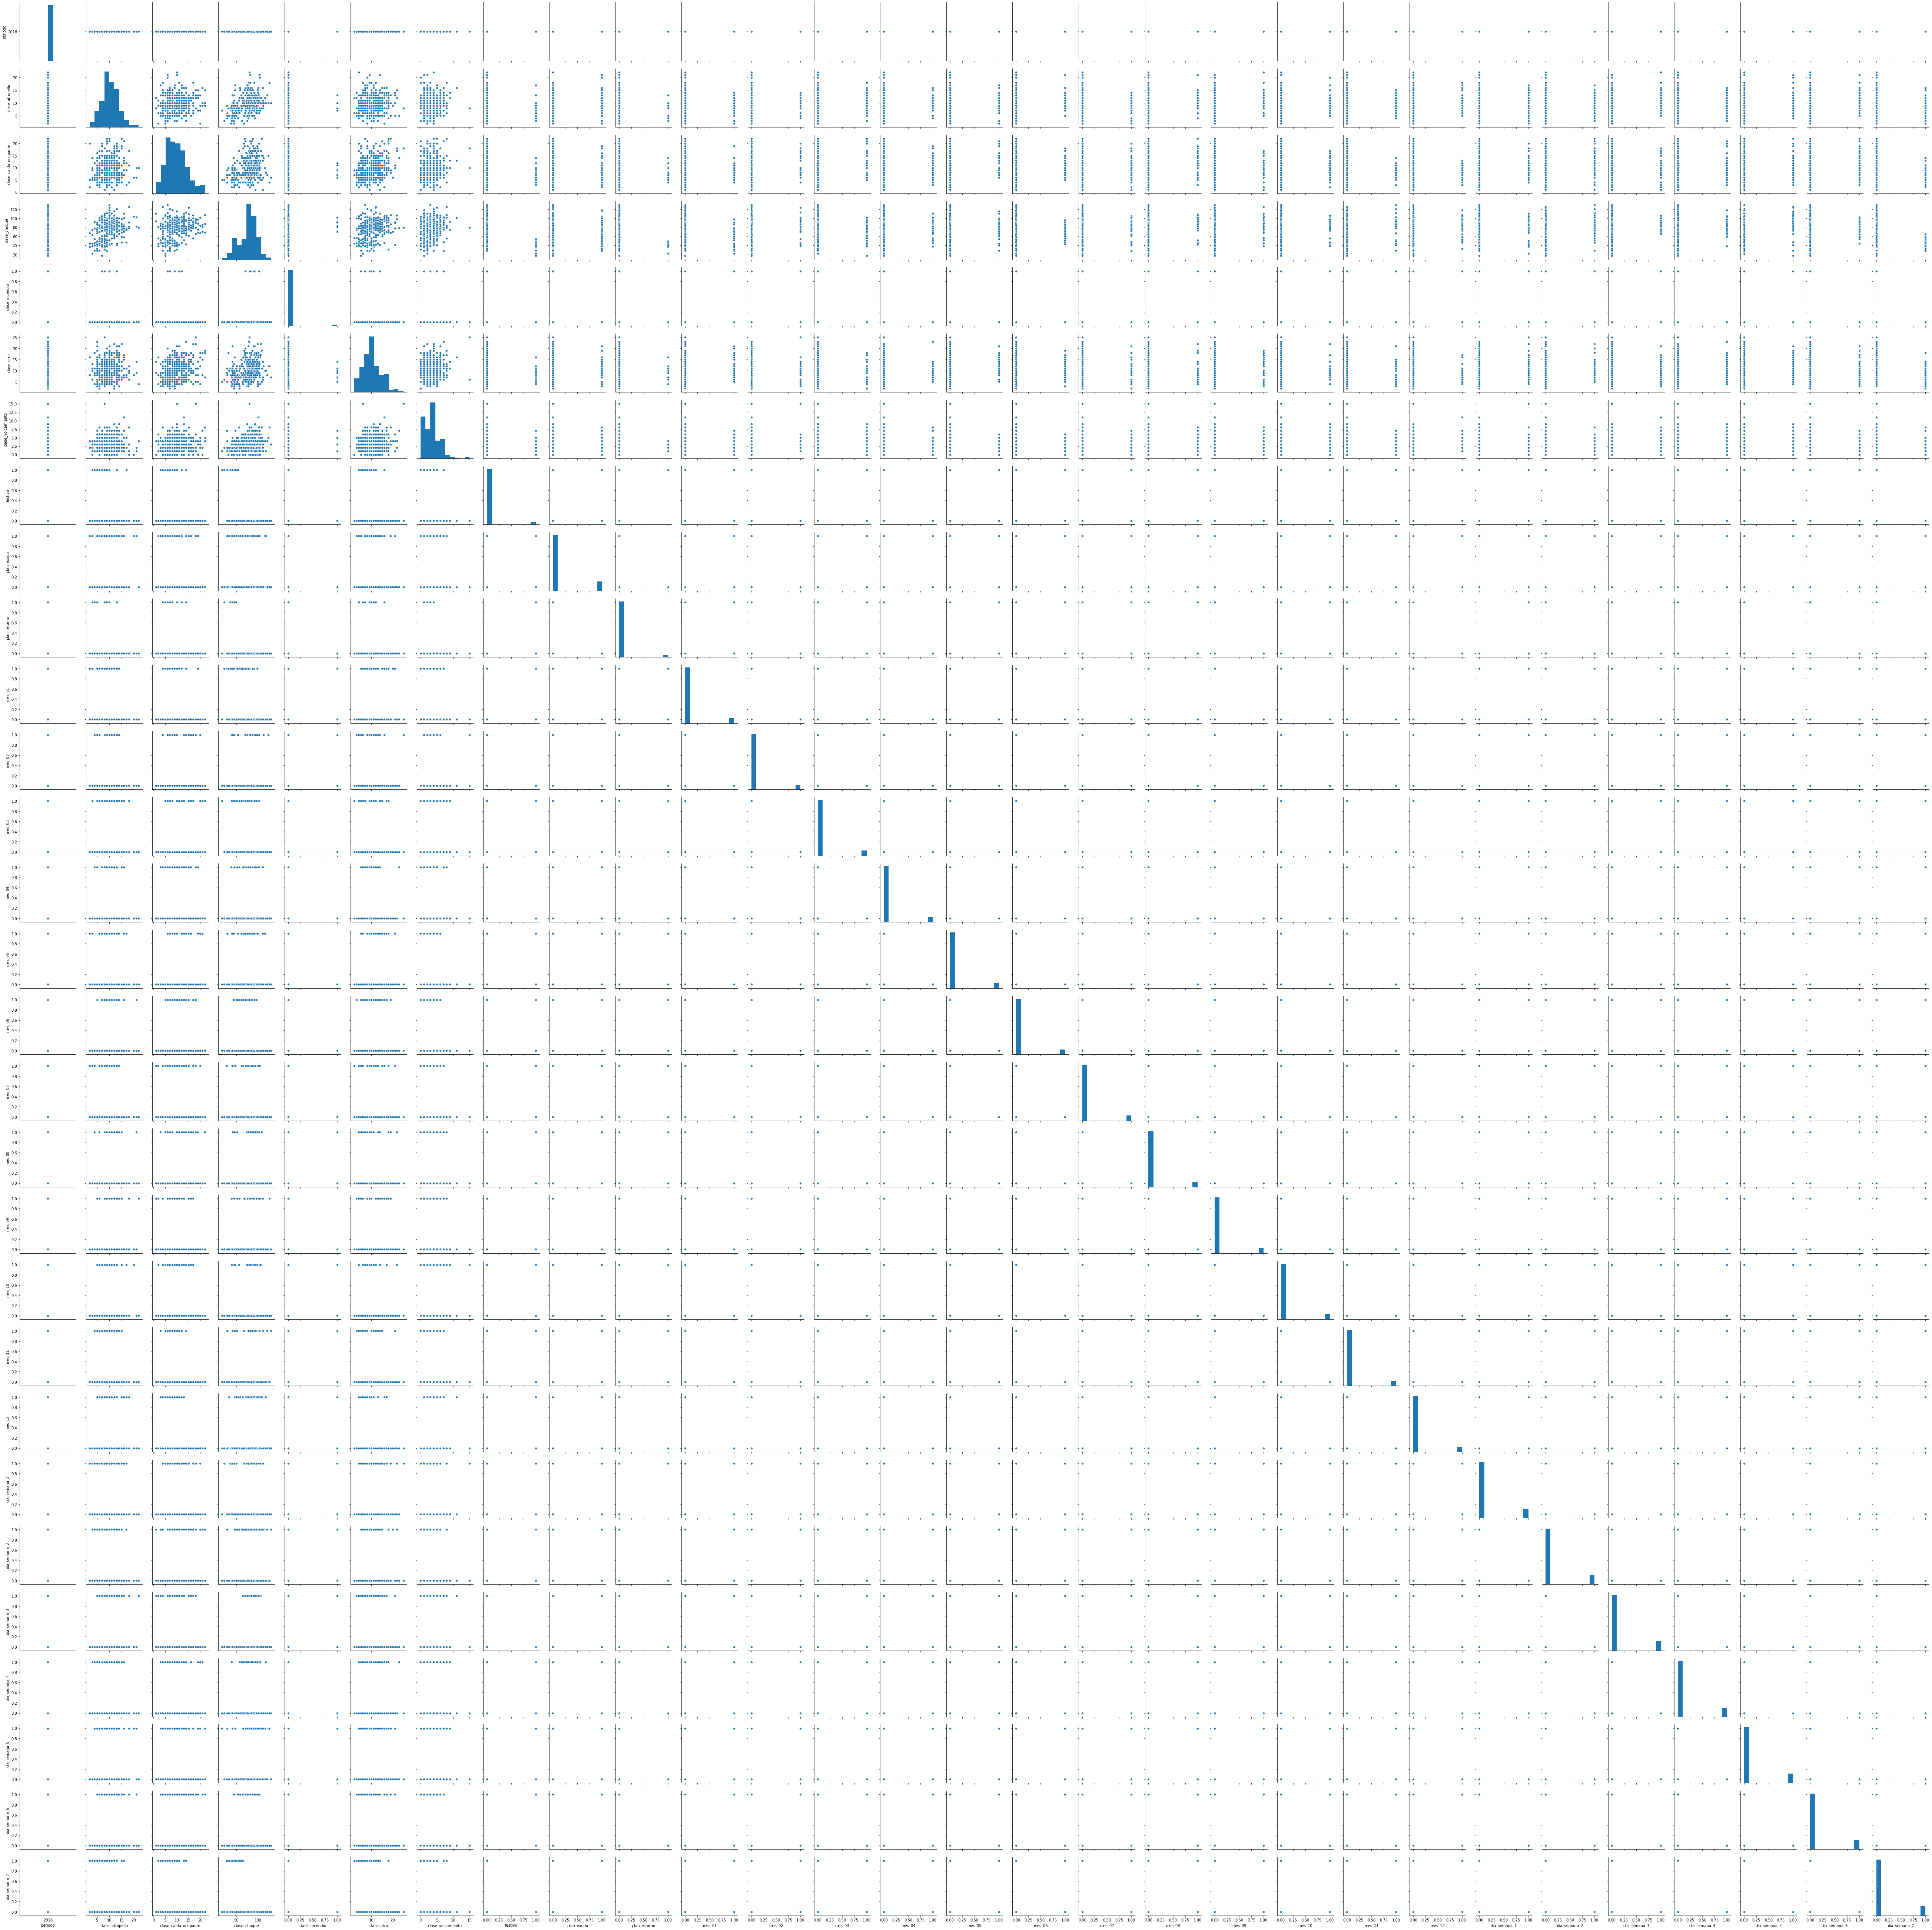

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Predictor relationship

sns.pairplot(df_test)

The relationship pairplot chart shows that there seems to be not a linear relationship between predictors and features, let's make zoom to some relationships

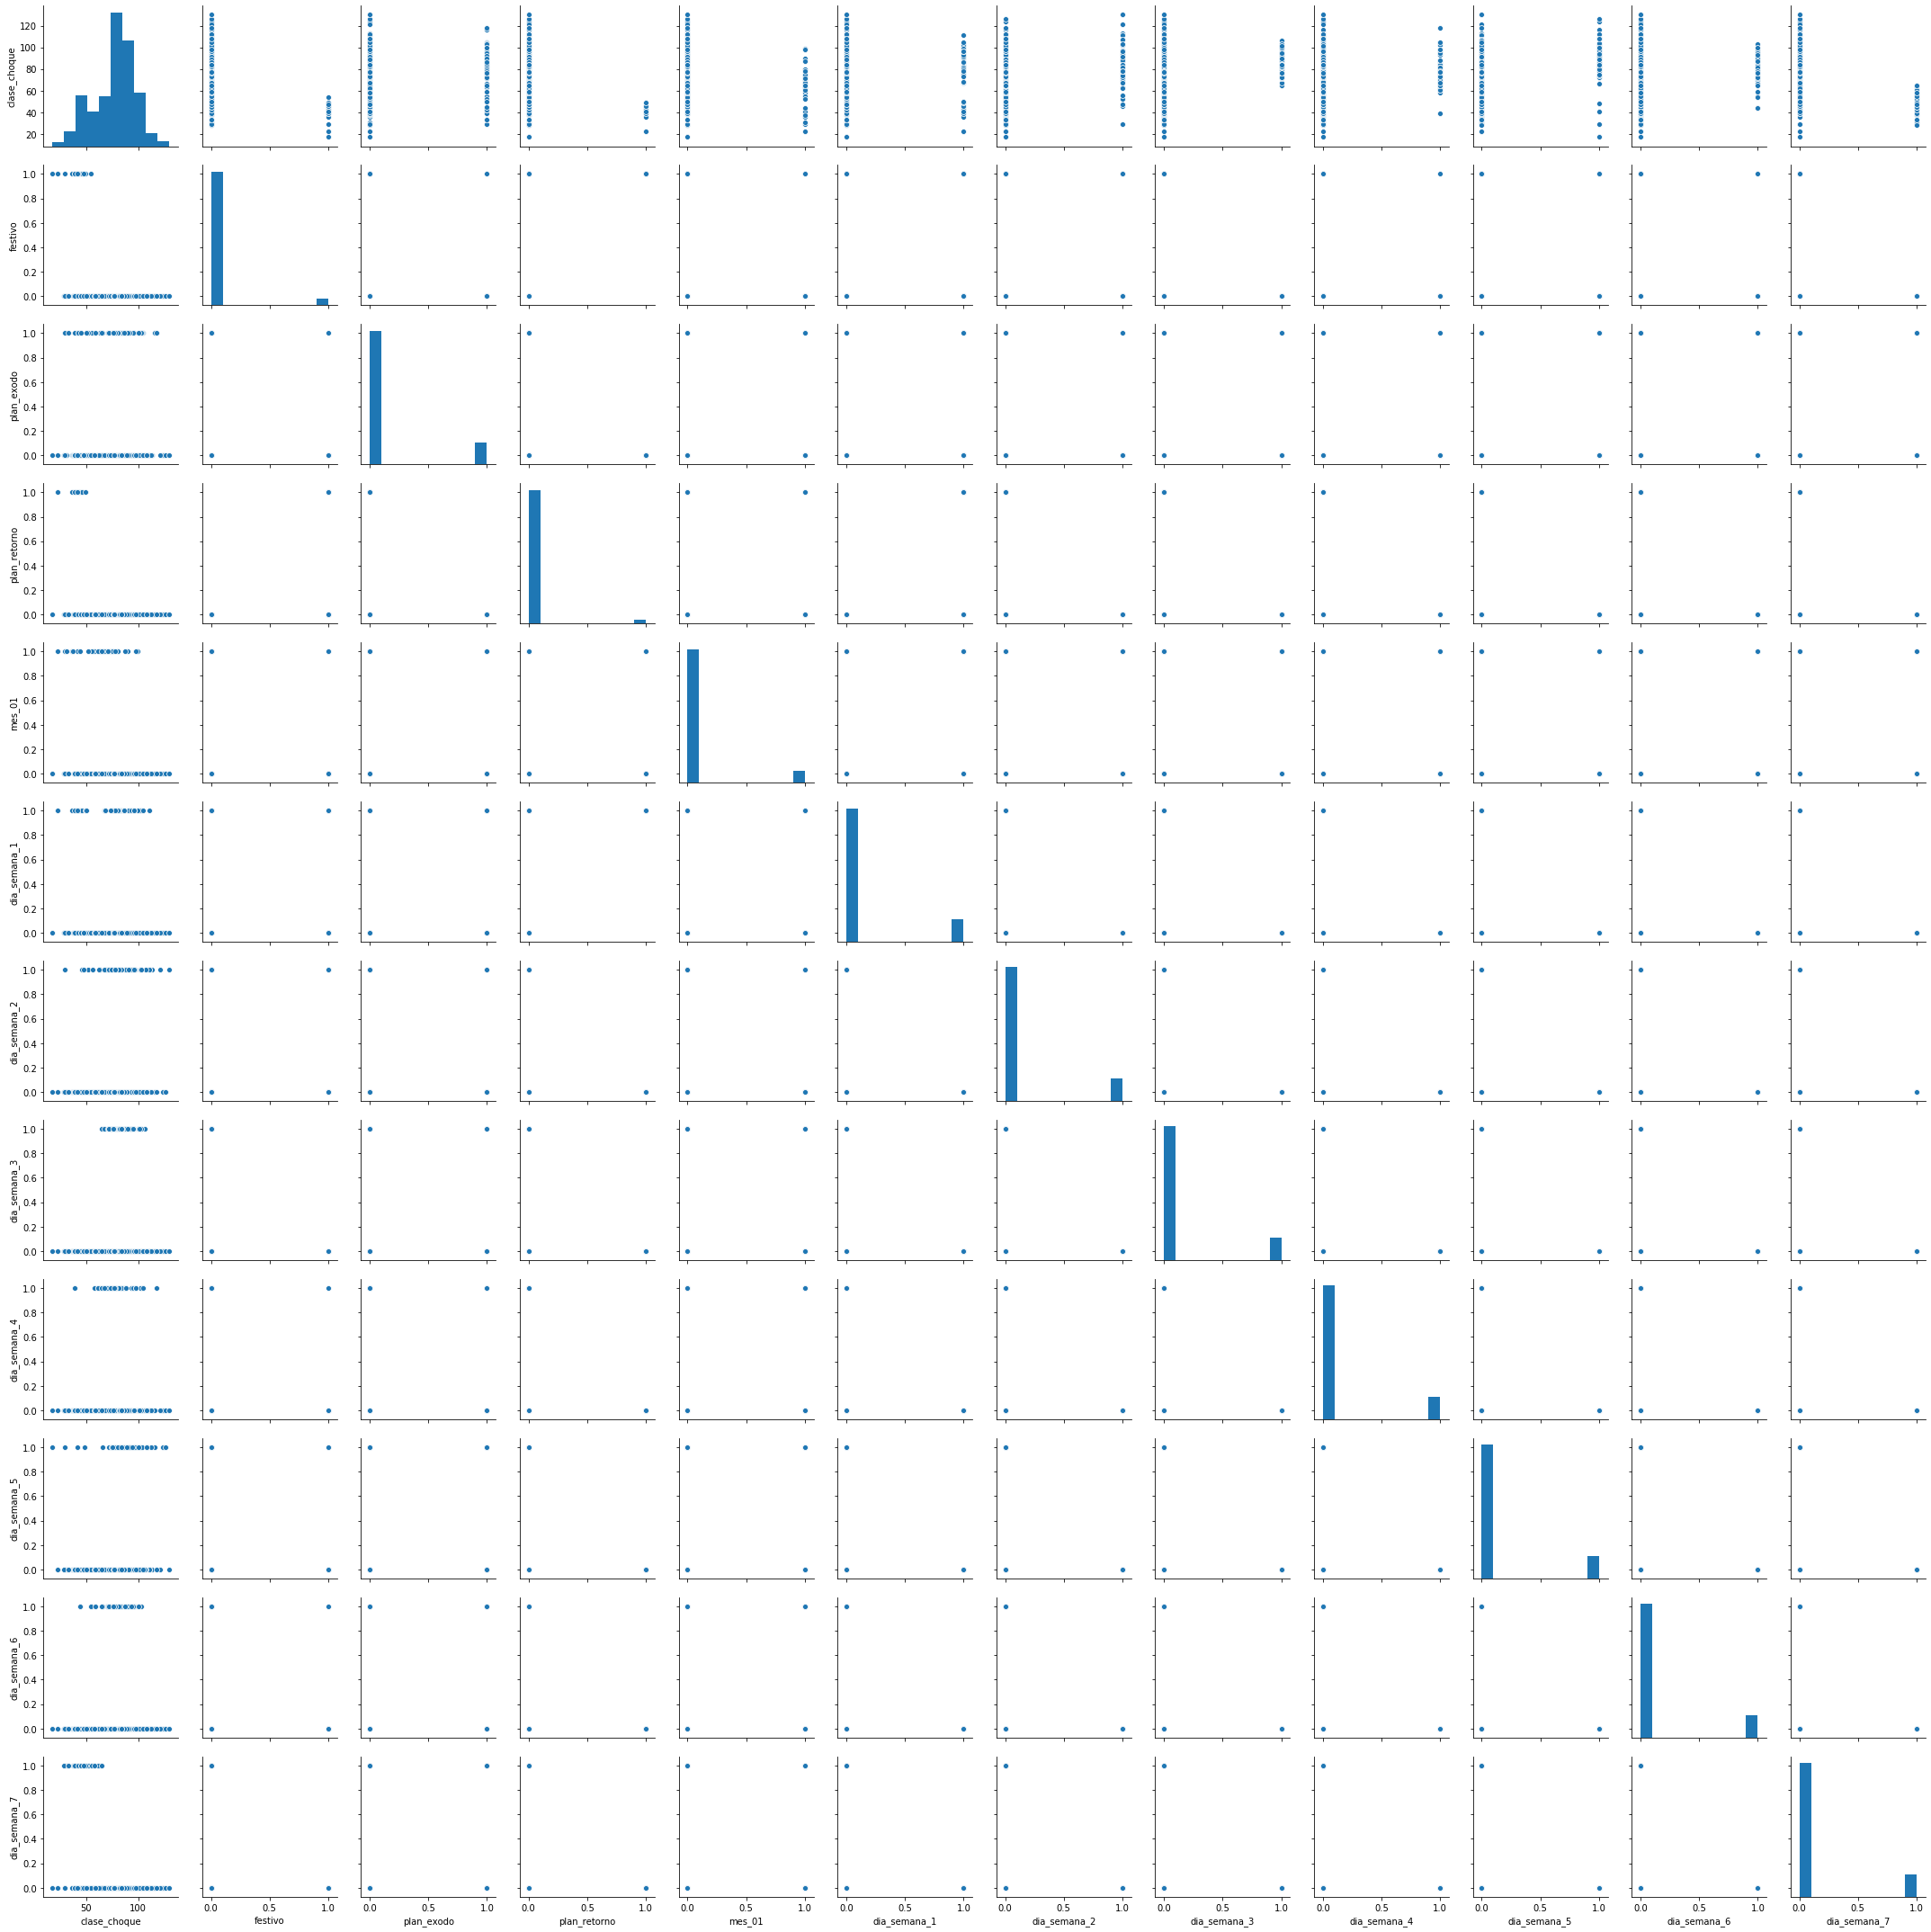

In [44]:
local_df = df_test[['clase_choque', 'festivo','plan_exodo', 'plan_retorno',
                    'mes_01', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3',
                    'dia_semana_4', 'dia_semana_5', 'dia_semana_6', 'dia_semana_7']]
sns.pairplot(local_df)